In [34]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import roc_auc_score, accuracy_score, mean_squared_error, confusion_matrix, f1_score
import xgboost as xgb

from utils import SOSEncoder, TargetEncoder

import warnings
warnings.filterwarnings('ignore')

## Configuration

In [2]:
DIR = 'D:\\PPrograms\\Python\\Kaggle\\Predicting Loan Pay\\'
TARGET = 'loan_paid_back'
SEED = 42

In [7]:
train = pd.read_csv(os.path.join(DIR, 'data\\train.csv'), index_col='id')
train, valid = train_test_split(train, test_size=0.2, random_state=SEED, stratify=train[TARGET])
test = pd.read_csv(os.path.join(DIR, 'data\\test.csv'), index_col='id')

In [8]:
nvp = np.sum(train[TARGET]==0)/np.sum(train[TARGET]==1)
print(f'The ratio of negative sample vs positive sample is {nvp}.')

The ratio of negative sample vs positive sample is 0.2518473636375611.


In [9]:
NUM = [col for col in test.columns if train[col].dtypes in ('float64', 'int64')]
CAT = [col for col in test.columns if train[col].dtypes in ('object',)]
COL = NUM + CAT
print(f'There are {test.shape[1]} cols, in which {len(NUM)} are numerical and {len(CAT)} are categorical.')

There are 11 cols, in which 5 are numerical and 6 are categorical.


## Feature Engineering
### Frequency

In [10]:
FREQ = []

sos = SOSEncoder(20)
def generate_frequency_feature(df, *df_other):
    train = pd.DataFrame(index=df.index)
    other = [pd.DataFrame(index=_.index) for _ in df_other]

    for col in COL:
        # --- Frequency Features ---
        # count the number of occurrences of each unique values
        freq= df[col].value_counts()
        col_name = f'{col}_freq'
        train[col_name] = df[col].map(freq)
        for i in range(len(other)):
            other[i][col_name] = df_other[i][col].map(freq).fillna(freq.mean())
        FREQ.append(col_name)
        # --- Bin Features ---
        # split the numerical col into bins
        if col in NUM:
            for q in [5, 10, 15]:
                train_bins, bins = pd.cut(df[col], bins=q, labels=False, retbins=True, duplicates="drop")
                col_name = f'{col}_bins{q}'
                train[col_name] = train_bins
                for i in range(len(other)):
                    other[i][col_name] = pd.cut(df_other[i][col], bins=bins, labels=False, duplicates="drop", include_lowest=True)

                FREQ.append(col_name)
    # --- Weighted Bins Features ---
    # split the numerical col into bins while label there weight
    res = sos.fit_transform(df[NUM])
    train = train.join(res)
    for i in range(len(other)):
        res = sos.transform(df_other[i][NUM])
        other[i] = other[i].join(res)

    FREQ.extend(sos.res_columns)

    # concatenate all features at once
    df = pd.concat([df, train], axis=1)
    for i in range(len(other)):
        other[i] = pd.concat([df_other[i], other[i]], axis=1)
    return df, *other

train, test, valid = generate_frequency_feature(train, *[test, valid])
print(f'{len(FREQ)} Frequency features created.')

136 Frequency features created.


### Subgrade

In [11]:
SUBGRADE = []

def generate_subgrade_feature(df, *df_other):
    grade_map = {
        'A': 0,
        'B': 1,
        'C': 2,
        'D': 3,
        'E': 4,
        'F': 5,
    }

    df['grade'] = df['grade_subgrade'].str[0].astype('category')
    df['ordered_grade'] = df['grade'].map(grade_map)
    df['subgrade'] = df['grade_subgrade'].str[1:].astype(int)
    for data in df_other:
        data['grade'] = data['grade_subgrade'].str[0].astype('category')
        data['ordered_grade'] = data['grade'].map(grade_map)
        data['subgrade'] = data['grade_subgrade'].str[1:].astype(int)
    SUBGRADE.append('grade')
    SUBGRADE.append('ordered_grade')
    SUBGRADE.append('subgrade')

    return df, *df_other

train, test, valid = generate_subgrade_feature(train, *[test, valid])
print(f'{len(SUBGRADE)} Subgrade features created.')

3 Subgrade features created.


### OrdCategory

In [12]:
ORDCATE = []
def generate_ordcategory_feature(df, *df_other):
    edu_map = {
        "Other": 0,
        "High School": 1,
        "Bachelor's": 2,
        "Master's": 3,
        "PhD": 4,
    }
    emp_map = {
        'Unemployed': 0,
        'Student': 1,
        'Self-employed': 2,
        'Employed': 3,
        'Retired': 4,
    }
    for data in [df, *df_other]:
        data['ordered_edu_level'] = data['education_level'].map(edu_map)
        data['ordered_employment_status'] = data['employment_status'].map(emp_map)
    ORDCATE.append('ordered_edu_level')
    ORDCATE.append('ordered_employment_status')

    return df, *df_other

train, test, valid = generate_ordcategory_feature(train, test, valid)
print(f'{len(ORDCATE)} Ordcategory features created.')

2 Ordcategory features created.


### Quadratic

In [114]:
INTER = []

def generate_quadratic_feature(df, *df_other):
    # values of fea 'annual_income' and 'loan_amount' are too much ,and they are not important in statistics in the meantime
    quadra_cols = combinations([col for col in COL if col not in ('annual_income', 'loan_amount')], 2)
    for col1, col2 in quadra_cols:
        col = f'{col1}_{col2}'
        for data in [df, *df_other]:
            data[col] = data[col1].astype(str) + '_' + data[col2].astype(str)
            data[col] = data[col].astype('category')
        INTER.append(col)

    return df, *df_other

train, test, valid = generate_quadratic_feature(train, test, valid)
print(f'{len(INTER)} Inter features created.')

36 Inter features created.


### Round

In [13]:
ROUND = []

def generate_round_feature(df, *df_other):
    rounding_levels = {
        '1r': 0,
        '10r': -1,
        '100r': -2
    }
    for col in ['annual_income', 'loan_amount']:
        for suffix, level in rounding_levels.items():
            col_name = f'{col}_{suffix}'
            for data in [df, *df_other]:
                data[col_name] = data[col].round(level).astype(int)

            ROUND.append(col_name)
    return df, *df_other

train, test, valid = generate_round_feature(train, test, valid)
print(f'{len(ROUND)} Round features created.')

6 Round features created.


### Target

In [14]:
TAR = []

tar = TargetEncoder(cols_to_encode=COL, aggs=['mean', 'count'], drop_original=True)
def generate_target_feature(df, *df_other):
    other = list(df_other)

    df_tar = tar.fit_transform(df[COL], df[TARGET])
    df = df.join(df_tar)
    for i in range(len(other)):
        other[i] = other[i].join(tar.transform(other[i][COL]))
    TAR.extend(df_tar.columns)

    return df, *other

train, test, valid = generate_target_feature(train, test, valid)
print(f'{len(TAR)} Target features created.')

22 Target features created.


In [15]:
for col in CAT:
    train[col] = train[col].astype('category')
    test[col] = test[col].astype('category')
    valid[col] = valid[col].astype('category')

In [16]:
FEATURES = CAT + NUM + TAR + ROUND + SUBGRADE + FREQ + ORDCATE
print(len(FEATURES), 'Features.')

180 Features.


## Feature Select

In [17]:
cv = 5
base_feas_select = []

In [18]:
def xgg_feature_test(X, y, cv=5, seed=42, **kwargs):
    kf = KFold(n_splits=cv, shuffle=True, random_state=seed)

    params = {
        'booster':'gbtree',
        'eval_metric': 'auc',
        "objective": "binary:logistic",
        "tree_method": "hist",
        "device": "cuda",
        'seed':seed
    }

    params.update(kwargs)

    res = {
        'auc': [],
        'acc': [],
        'rmse': [],
    }
    for FOLD, (train_idx, val_idx) in enumerate(kf.split(X, y)):

        print(f"\n{'#'*25}")
        print(f"### FOLD : {FOLD+1} ###")
        print(f"{'#'*25}\n")

        x_train = X.iloc[train_idx].copy()
        y_train = y.iloc[train_idx].copy()
        x_val = X.iloc[val_idx].copy()
        y_val = y.iloc[val_idx].copy()

        dtrain = xgb.DMatrix(x_train, label=y_train, enable_categorical=True)
        dval = xgb.DMatrix(x_val, label=y_val, enable_categorical=True)

        model = xgb.train(
            params=params,
            dtrain=dtrain,
            num_boost_round=10000,
            evals=[(dtrain, "train"), (dval, "valid")],
            early_stopping_rounds=200,
            verbose_eval=1000
        )

        y_pred_proba = model.predict(dval)
        if params['eval_metric'] == 'auc':
            # auc
            fold_auc = roc_auc_score(y_val, y_pred_proba)
            res['auc'].append(fold_auc)
            # acc
            y_pred = (y_pred_proba > 0.5).astype(int)  # 以0.5为阈值将概率转换为0/1标签
            fold_accuracy = accuracy_score(y_val, y_pred)
            res['acc'].append(fold_accuracy)
            print(f"FOLD {FOLD+1} AUC: {fold_auc:.5f} ACC: {fold_accuracy:.5f}")
        else:
            # rmse
            fold_rmse = mean_squared_error(y_val, y_pred_proba)
            res['rmse'].append(fold_rmse)
            print(f"FOLD {FOLD+1} RMSE: {fold_rmse:.5f}")

    print("\n" + "="*50)
    if params['eval_metric'] == 'auc':
        print(f"MEAN AUC: {np.mean(res['auc']):.5f}, ACC: {np.mean(res['acc']):.5f}")
        ret = (np.mean(res['auc']), np.mean(res['acc']))
    else:
        print(f"MEAN RMSE: {np.mean(res['rmse']):.5f}")
        ret = (np.mean(res['rmse']),)
    print("="*50)

    return ret

In [19]:
base_feas_select.append(('RAW', xgg_feature_test(train[COL], train[TARGET], cv=cv, seed=SEED)))


#########################
### FOLD : 1 ###
#########################

[0]	train-auc:0.91055	valid-auc:0.90941
[288]	train-auc:0.95353	valid-auc:0.91626
FOLD 1 AUC: 0.91624 ACC: 0.90307

#########################
### FOLD : 2 ###
#########################

[0]	train-auc:0.91005	valid-auc:0.91055
[297]	train-auc:0.95425	valid-auc:0.91718
FOLD 2 AUC: 0.91719 ACC: 0.90305

#########################
### FOLD : 3 ###
#########################

[0]	train-auc:0.91052	valid-auc:0.90957
[278]	train-auc:0.95240	valid-auc:0.91671
FOLD 3 AUC: 0.91671 ACC: 0.90295

#########################
### FOLD : 4 ###
#########################

[0]	train-auc:0.91004	valid-auc:0.91011
[268]	train-auc:0.95190	valid-auc:0.91728
FOLD 4 AUC: 0.91728 ACC: 0.90323

#########################
### FOLD : 5 ###
#########################

[0]	train-auc:0.91063	valid-auc:0.90847
[281]	train-auc:0.95238	valid-auc:0.91595
FOLD 5 AUC: 0.91595 ACC: 0.90296

MEAN AUC: 0.91667, ACC: 0.90305


In [20]:
base_feas_select.append(('FREQ', xgg_feature_test(train[COL+FREQ], train[TARGET], cv=cv, seed=SEED)))


#########################
### FOLD : 1 ###
#########################

[0]	train-auc:0.91080	valid-auc:0.90946
[292]	train-auc:0.96055	valid-auc:0.91860
FOLD 1 AUC: 0.91860 ACC: 0.90569

#########################
### FOLD : 2 ###
#########################

[0]	train-auc:0.91042	valid-auc:0.91102
[312]	train-auc:0.96202	valid-auc:0.91910
FOLD 2 AUC: 0.91910 ACC: 0.90493

#########################
### FOLD : 3 ###
#########################

[0]	train-auc:0.91079	valid-auc:0.90968
[273]	train-auc:0.95954	valid-auc:0.91870
FOLD 3 AUC: 0.91870 ACC: 0.90538

#########################
### FOLD : 4 ###
#########################

[0]	train-auc:0.91063	valid-auc:0.91092
[270]	train-auc:0.95754	valid-auc:0.92011
FOLD 4 AUC: 0.92011 ACC: 0.90590

#########################
### FOLD : 5 ###
#########################

[0]	train-auc:0.91084	valid-auc:0.90862
[274]	train-auc:0.95992	valid-auc:0.91777
FOLD 5 AUC: 0.91777 ACC: 0.90550

MEAN AUC: 0.91886, ACC: 0.90548


In [21]:
base_feas_select.append(('ORDER', xgg_feature_test(train[COL+ORDCATE], train[TARGET], cv=cv, seed=SEED)))


#########################
### FOLD : 1 ###
#########################

[0]	train-auc:0.91055	valid-auc:0.90941
[275]	train-auc:0.95218	valid-auc:0.91683
FOLD 1 AUC: 0.91683 ACC: 0.90238

#########################
### FOLD : 2 ###
#########################

[0]	train-auc:0.91005	valid-auc:0.91055
[311]	train-auc:0.95519	valid-auc:0.91725
FOLD 2 AUC: 0.91723 ACC: 0.90282

#########################
### FOLD : 3 ###
#########################

[0]	train-auc:0.91052	valid-auc:0.90957
[285]	train-auc:0.95266	valid-auc:0.91707
FOLD 3 AUC: 0.91707 ACC: 0.90286

#########################
### FOLD : 4 ###
#########################

[0]	train-auc:0.91004	valid-auc:0.91011
[280]	train-auc:0.95235	valid-auc:0.91642
FOLD 4 AUC: 0.91637 ACC: 0.90297

#########################
### FOLD : 5 ###
#########################

[0]	train-auc:0.91063	valid-auc:0.90847
[287]	train-auc:0.95359	valid-auc:0.91546
FOLD 5 AUC: 0.91546 ACC: 0.90307

MEAN AUC: 0.91659, ACC: 0.90282


In [23]:
base_feas_select.append(('ROUND', xgg_feature_test(train[COL+ROUND], train[TARGET], cv=cv, seed=SEED)))


#########################
### FOLD : 1 ###
#########################

[0]	train-auc:0.91055	valid-auc:0.90941
[281]	train-auc:0.95327	valid-auc:0.91711
FOLD 1 AUC: 0.91711 ACC: 0.90260

#########################
### FOLD : 2 ###
#########################

[0]	train-auc:0.91005	valid-auc:0.91055
[294]	train-auc:0.95412	valid-auc:0.91758
FOLD 2 AUC: 0.91756 ACC: 0.90365

#########################
### FOLD : 3 ###
#########################

[0]	train-auc:0.91052	valid-auc:0.90957
[289]	train-auc:0.95405	valid-auc:0.91669
FOLD 3 AUC: 0.91665 ACC: 0.90280

#########################
### FOLD : 4 ###
#########################

[0]	train-auc:0.91004	valid-auc:0.91011
[268]	train-auc:0.95216	valid-auc:0.91722
FOLD 4 AUC: 0.91722 ACC: 0.90333

#########################
### FOLD : 5 ###
#########################

[0]	train-auc:0.91063	valid-auc:0.90847
[281]	train-auc:0.95316	valid-auc:0.91591
FOLD 5 AUC: 0.91591 ACC: 0.90363

MEAN AUC: 0.91689, ACC: 0.90320


In [22]:
base_feas_select.append(('SUBGRADE', xgg_feature_test(train[COL+SUBGRADE], train[TARGET], cv=cv, seed=SEED)))


#########################
### FOLD : 1 ###
#########################

[0]	train-auc:0.91055	valid-auc:0.90941
[309]	train-auc:0.95549	valid-auc:0.91605
FOLD 1 AUC: 0.91605 ACC: 0.90249

#########################
### FOLD : 2 ###
#########################

[0]	train-auc:0.91005	valid-auc:0.91055
[283]	train-auc:0.95293	valid-auc:0.91758
FOLD 2 AUC: 0.91758 ACC: 0.90299

#########################
### FOLD : 3 ###
#########################

[0]	train-auc:0.91052	valid-auc:0.90957
[289]	train-auc:0.95332	valid-auc:0.91686
FOLD 3 AUC: 0.91686 ACC: 0.90279

#########################
### FOLD : 4 ###
#########################

[0]	train-auc:0.91004	valid-auc:0.91011
[289]	train-auc:0.95390	valid-auc:0.91645
FOLD 4 AUC: 0.91646 ACC: 0.90292

#########################
### FOLD : 5 ###
#########################

[0]	train-auc:0.91063	valid-auc:0.90847
[310]	train-auc:0.95560	valid-auc:0.91525
FOLD 5 AUC: 0.91525 ACC: 0.90241

MEAN AUC: 0.91644, ACC: 0.90272


In [24]:
base_feas_select.append(('TAR', xgg_feature_test(train[COL+TAR], train[TARGET], cv=cv, seed=SEED)))


#########################
### FOLD : 1 ###
#########################

[0]	train-auc:0.91795	valid-auc:0.91689
[229]	train-auc:0.95882	valid-auc:0.92051
FOLD 1 AUC: 0.92051 ACC: 0.90680

#########################
### FOLD : 2 ###
#########################

[0]	train-auc:0.91788	valid-auc:0.91879
[236]	train-auc:0.95912	valid-auc:0.92271
FOLD 2 AUC: 0.92272 ACC: 0.90640

#########################
### FOLD : 3 ###
#########################

[0]	train-auc:0.91765	valid-auc:0.91712
[231]	train-auc:0.95886	valid-auc:0.92038
FOLD 3 AUC: 0.92038 ACC: 0.90640

#########################
### FOLD : 4 ###
#########################

[0]	train-auc:0.91787	valid-auc:0.91722
[234]	train-auc:0.95932	valid-auc:0.92056
FOLD 4 AUC: 0.92056 ACC: 0.90683

#########################
### FOLD : 5 ###
#########################

[0]	train-auc:0.91831	valid-auc:0.91580
[227]	train-auc:0.95867	valid-auc:0.91916
FOLD 5 AUC: 0.91915 ACC: 0.90674

MEAN AUC: 0.92066, ACC: 0.90663


In [25]:
base_feas_select.sort(key=lambda x: x[1][0], reverse=True)
print('#'*25)
print('### feature selection rank ###')
print(f"{'#'*25}\n")
for i, (fea, (auc, acc)) in enumerate(base_feas_select):
    print(f'{i+1} {fea} AUC: {auc:.5f} ACC: {acc:.5f}')

#########################
### feature selection rank ###
#########################

1 TAR AUC: 0.92066 ACC: 0.90663
2 FREQ AUC: 0.91886 ACC: 0.90548
3 ROUND AUC: 0.91689 ACC: 0.90320
4 RAW AUC: 0.91667 ACC: 0.90305
5 ORDER AUC: 0.91659 ACC: 0.90282
6 SUBGRADE AUC: 0.91644 ACC: 0.90272


## BASE MODEL

In [30]:
import optuna

def objective(trial, X, y_true, y_pred_prev, n_splits=5, seed=42):
    """
    Objective for Optuna that tunes residual-based XGBoost using 5-fold CV.
    Evaluates RMSE on actual target (not residuals).

    Parameters
    ----------
    X : pd.DataFrame or np.ndarray
        Feature matrix
    y_true : np.ndarray
        True target values
    y_pred_prev : np.ndarray or None
        Previous model predictions (for residual correction)
    n_splits : int
        Number of CV folds
    """

    # Judge the type of model (base or residual), then select different objective function and eval metric
    if y_pred_prev is None:
        obj = "binary:logistic"
        eval_metric = "auc"
    else:
        obj = "reg:squarederror"
        eval_metric = "rmse"

    # --- Hyperparameter search space ---
    param = {
        "objective": obj,
        "eval_metric": eval_metric,
        "tree_method": "hist",
        "device": "cuda",
        'booster': 'gbtree',
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "min_child_weight": trial.suggest_float("min_child_weight", 1, 15),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 2.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.5, 5.0, log=True),
        "gamma": trial.suggest_float("gamma", 0.0, 5.0),
        "max_leaves": trial.suggest_int("max_leaves", 4, 32),
    }

    # use a small learning_rate when construct residual model
    if y_pred_prev is not None:
        param.update({
            "learning_rate": 0.005,
        })
    else:
        y_pred_prev = pd.Series(data=np.zeros_like(y_true), index=X.index)
        param.update({
            "scale_pos_weight": nvp,
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.15),
        })

    # --- cal residual ---
    y_resid = y_true - y_pred_prev

    # --- 5-Fold CV ---
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=seed)
    auc_scores = []

    for fold, (train_idx, valid_idx) in enumerate(kf.split(X)):
        X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
        y_resid_train, y_resid_valid = y_resid.iloc[train_idx], y_resid.iloc[valid_idx]


        dtrain = xgb.DMatrix(X_train, label=y_resid_train, enable_categorical=True)
        dvalid = xgb.DMatrix(X_valid, label=y_resid_valid, enable_categorical=True)

        # Train residual model
        model = xgb.train(
            params=param,
            dtrain=dtrain,
            num_boost_round=10000 if y_pred_prev is None else 3000,
            evals=[(dtrain, "train"), (dvalid, "valid")],
            early_stopping_rounds=100 if y_pred_prev is None else 10000,
            verbose_eval=False,
        )

        # Predict probs
        preds = model.predict(dvalid, iteration_range=(0, model.best_iteration + 1))

        # integrate model predictions
        preds_proba = np.clip(preds + y_pred_prev.iloc[valid_idx], 0, 1)

        # auc
        fold_auc = roc_auc_score(y_true.iloc[valid_idx], preds_proba)
        auc_scores.append(fold_auc)

    # --- Aggregate fold scores ---
    mean_auc = np.mean(auc_scores)
    print(f"Trial {trial.number}: CV AUC = {mean_auc:.5f}")

    # Optuna minimizes AUC ACC directly
    return mean_auc


def tune_xgb_with_optuna(X, y_true, y_pred_prev=None, n_trials=10, timeout=900, n_splits=5, seed=42):
    """
    Run Optuna hyperparameter tuning with 5-fold CV.
    """

    print(f"Starting Optuna tuning with {n_splits}-fold CV on residuals...")
    study = optuna.create_study(direction="maximize", study_name="xgb_cv_tuning")
    study.optimize(
        lambda trial: objective(trial, X, y_true, y_pred_prev, n_splits=n_splits, seed=seed),
        n_trials=n_trials,
        timeout=timeout,
        show_progress_bar=True
    )

    # --- Report best result ---
    trial = study.best_trial
    print("\nBest trial summary:")
    print(f"  • Best AUC: {trial.value:.6f}")
    print(f"  • Best parameters: {trial.params}")
    return trial.params, trial.value

In [31]:
base_param = tune_xgb_with_optuna(train[COL+TAR+FREQ+ROUND+SUBGRADE+ORDCATE], train[TARGET], seed=SEED)

[I 2025-11-16 20:37:07,544] A new study created in memory with name: xgb_cv_tuning


Starting Optuna tuning with 5-fold CV on residuals...


Best trial: 0. Best value: 0.9259:  10%|█         | 1/10 [03:12<28:52, 192.54s/it, 192.54/900 seconds]

Trial 0: CV AUC = 0.92590
[I 2025-11-16 20:40:20,094] Trial 0 finished with value: 0.9259002005469583 and parameters: {'max_depth': 9, 'min_child_weight': 6.11225386432281, 'subsample': 0.6114876420286958, 'colsample_bytree': 0.910718597062134, 'reg_alpha': 1.6157025679705606, 'reg_lambda': 1.2253581701060712, 'gamma': 4.38613898924123, 'max_leaves': 10, 'learning_rate': 0.09770186543966383}. Best is trial 0 with value: 0.9259002005469583.


Best trial: 0. Best value: 0.9259:  20%|██        | 2/10 [06:46<27:20, 205.05s/it, 406.35/900 seconds]

Trial 1: CV AUC = 0.92583
[I 2025-11-16 20:43:53,910] Trial 1 finished with value: 0.9258312723480289 and parameters: {'max_depth': 5, 'min_child_weight': 2.9819796336141997, 'subsample': 0.8125140983733422, 'colsample_bytree': 0.7725995638843044, 'reg_alpha': 0.29862482688134007, 'reg_lambda': 3.675903872035427, 'gamma': 1.2075898784186774, 'max_leaves': 8, 'learning_rate': 0.1462129012826417}. Best is trial 0 with value: 0.9259002005469583.


Best trial: 0. Best value: 0.9259:  30%|███       | 3/10 [10:16<24:10, 207.16s/it, 616.01/900 seconds]

Trial 2: CV AUC = 0.92582
[I 2025-11-16 20:47:23,574] Trial 2 finished with value: 0.9258206492974344 and parameters: {'max_depth': 6, 'min_child_weight': 9.25891680035684, 'subsample': 0.776149667796921, 'colsample_bytree': 0.7495077340512502, 'reg_alpha': 1.8238833667153167, 'reg_lambda': 0.5732014219609517, 'gamma': 2.538724464058058, 'max_leaves': 32, 'learning_rate': 0.05321181519897781}. Best is trial 0 with value: 0.9259002005469583.


Best trial: 0. Best value: 0.9259:  40%|████      | 4/10 [13:19<19:47, 197.95s/it, 799.83/900 seconds]

Trial 3: CV AUC = 0.92553
[I 2025-11-16 20:50:27,397] Trial 3 finished with value: 0.925533898049918 and parameters: {'max_depth': 10, 'min_child_weight': 5.378095825311309, 'subsample': 0.8276643072050341, 'colsample_bytree': 0.6925060301757844, 'reg_alpha': 0.8172779060305788, 'reg_lambda': 1.1361827710893297, 'gamma': 2.8191437264810832, 'max_leaves': 17, 'learning_rate': 0.10032010106203393}. Best is trial 0 with value: 0.9259002005469583.


Best trial: 0. Best value: 0.9259:  50%|█████     | 5/10 [16:31<16:31, 198.38s/it, 991.87/900 seconds]

Trial 4: CV AUC = 0.92537
[I 2025-11-16 20:53:39,433] Trial 4 finished with value: 0.9253679313908452 and parameters: {'max_depth': 9, 'min_child_weight': 2.077051501141054, 'subsample': 0.9826388821823231, 'colsample_bytree': 0.6208481296511908, 'reg_alpha': 1.89600725263453, 'reg_lambda': 2.973466991717986, 'gamma': 3.0544470173942653, 'max_leaves': 24, 'learning_rate': 0.021932282130819797}. Best is trial 0 with value: 0.9259002005469583.

Best trial summary:
  • Best AUC: 0.925900
  • Best parameters: {'max_depth': 9, 'min_child_weight': 6.11225386432281, 'subsample': 0.6114876420286958, 'colsample_bytree': 0.910718597062134, 'reg_alpha': 1.6157025679705606, 'reg_lambda': 1.2253581701060712, 'gamma': 4.38613898924123, 'max_leaves': 10, 'learning_rate': 0.09770186543966383}


In [32]:
# Save base model params
with open(os.path.join(DIR, 'model\\scale_weight\\base_param.json'), 'w') as f:
    json.dump(base_param[0], f, indent=4)

In [37]:
with open(os.path.join(DIR, 'model\\scale_weight\\base_param.json'), 'r') as f:
    param = json.load(f)
param.update({
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "tree_method": "hist",
    "device": "cuda",
    'booster': 'gbtree',
    'seed': SEED,
    'scale_pos_weight': nvp,
})

cv=5
used_feas = COL+TAR+FREQ+ROUND+SUBGRADE+ORDCATE
kf = KFold(n_splits=cv, shuffle=True, random_state=SEED)

train_fsp = np.zeros(train.shape[0])
valid_fsp = np.zeros(valid.shape[0])
test_fsp = np.zeros(test.shape[0]) # contain the predictions of test data by base model using cv
auc_res = []
acc_res = []
f1_res = []
for fold, (train_idx, valid_idx) in enumerate(kf.split(train)):
    X_train, X_valid = train[used_feas].iloc[train_idx], train[used_feas].iloc[valid_idx]
    y_train, y_valid = train[TARGET].iloc[train_idx], train[TARGET].iloc[valid_idx]

    dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical=True)
    dvalid = xgb.DMatrix(X_valid, label=y_valid, enable_categorical=True)
    dtest = xgb.DMatrix(test[used_feas], enable_categorical=True)
    DVALID = xgb.DMatrix(valid[used_feas], enable_categorical=True)

    # Train base model
    model = xgb.train(
        params=param,
        dtrain=dtrain,
        num_boost_round=10000,
        evals=[(dtrain, "train"), (dvalid, "valid")],
        early_stopping_rounds=100,
        verbose_eval=False,
    )

    # Predict probs
    valid_preds = model.predict(dvalid, iteration_range=(0, model.best_iteration + 1))
    train_fsp[valid_idx] = valid_preds
    test_fsp += model.predict(dtest, iteration_range=(0, model.best_iteration + 1))
    valid_fsp += model.predict(DVALID, iteration_range=(0, model.best_iteration + 1))
    # auc
    auc = roc_auc_score(y_valid, valid_preds)
    auc_res.append(auc)
    # acc
    y_pred = (valid_preds > 0.5).astype(int)
    acc = accuracy_score(y_valid, y_pred)
    acc_res.append(acc)
    # f1
    f1 = f1_score(y_valid, y_pred)
    f1_res.append(f1)
    print(f'{fold+1} auc = {auc:.5f} acc = {acc:.5f} f1 = {f1:.5f}')


test_fsp /= cv
valid_fsp /= cv
# Save test data predictions
pd.DataFrame(data={'id': train.index, TARGET: train_fsp}).to_csv(os.path.join(DIR, 'sub\\scale_weight\\train_fsp.csv'),index=False,header=True)
pd.DataFrame(data={'id': test.index, TARGET: test_fsp}).to_csv(os.path.join(DIR, 'sub\\scale_weight\\test_fsp.csv'),index=False,header=True)
pd.DataFrame(data={'id': valid.index, TARGET: valid_fsp}).to_csv(os.path.join(DIR, 'sub\\scale_weight\\valid_fsp.csv'),index=False,header=True)
# np.save(os.path.join(DIR, 'data\\test_fsp.npy'), test_fsp)
# np.save(os.path.join(DIR, 'data\\train_fsp.npy'), train_fsp)

print(f'BASE MODEL AUC = {np.mean(auc_res):.5f} ACC = {np.mean(acc_res):.5f} F1 = {np.mean(f1_res):.5f}.')
print(f'BASE MODEL ON VALID DATA AUC = {roc_auc_score(valid[TARGET], valid_fsp)} ACC = {accuracy_score(valid[TARGET], (valid_fsp>0.5).astype(int))} F1 = {f1_score(valid[TARGET], (valid_fsp>0.5).astype(int))}')

1 auc = 0.92586 acc = 0.86773 f1 = 0.91435
2 auc = 0.92718 acc = 0.87197 f1 = 0.91731
3 auc = 0.92591 acc = 0.87112 f1 = 0.91679
4 auc = 0.92619 acc = 0.87137 f1 = 0.91686
5 auc = 0.92161 acc = 0.75893 f1 = 0.82783
BASE MODEL AUC = 0.92535 ACC = 0.84822 F1 = 0.89863.
BASE MODEL ON VALID DATA AUC = 0.9256196898786162 ACC = 0.8700073232939671 F1 = 0.9159916660773445


混淆矩阵:
[[19164  4736]
 [10707 84192]]


Text(0.5, 1.0, 'confussion')

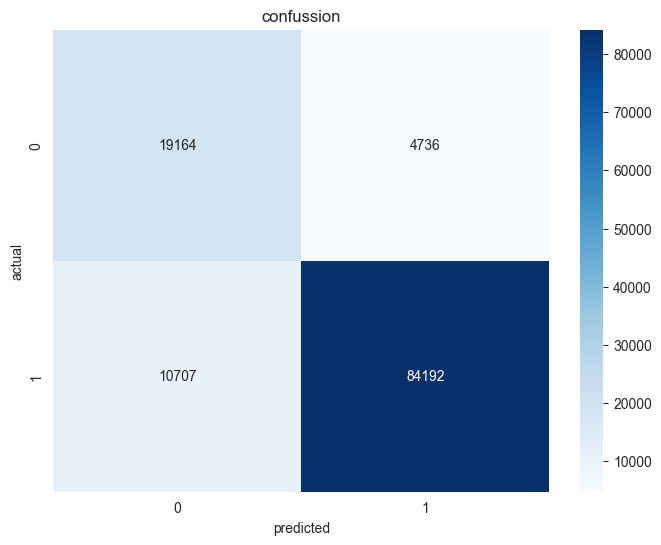

In [38]:
# 计算混淆矩阵
cm = confusion_matrix(valid[TARGET], (valid_fsp > 0.5).astype(int))
print("混淆矩阵:")
print(cm)

# 可视化混淆矩阵
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('predicted')
plt.ylabel('actual')
plt.title('confussion')

## RESIDUAL MODEL

In [39]:
train_fsp = pd.read_csv(os.path.join(DIR, 'sub\\scale_weight\\train_fsp.csv'), index_col='id')
resid = train[TARGET] - train_fsp[TARGET]

In [40]:
cv = 5
resid_feas_select = []

In [41]:
resid_feas_select.append(('RAW', xgg_feature_test(train[COL], resid, cv=cv, eval_metric='rmse', objective='reg:squarederror')))


#########################
### FOLD : 1 ###
#########################

[0]	train-rmse:0.28720	valid-rmse:0.27816
[220]	train-rmse:0.25700	valid-rmse:0.27286
FOLD 1 RMSE: 0.07445

#########################
### FOLD : 2 ###
#########################

[0]	train-rmse:0.28739	valid-rmse:0.27668
[208]	train-rmse:0.25748	valid-rmse:0.27224
FOLD 2 RMSE: 0.07411

#########################
### FOLD : 3 ###
#########################

[0]	train-rmse:0.28718	valid-rmse:0.27770
[208]	train-rmse:0.25736	valid-rmse:0.27350
FOLD 3 RMSE: 0.07480

#########################
### FOLD : 4 ###
#########################

[0]	train-rmse:0.28720	valid-rmse:0.27730
[206]	train-rmse:0.25762	valid-rmse:0.27298
FOLD 4 RMSE: 0.07452

#########################
### FOLD : 5 ###
#########################

[0]	train-rmse:0.27677	valid-rmse:0.32538
[250]	train-rmse:0.24720	valid-rmse:0.30774
FOLD 5 RMSE: 0.09471

MEAN RMSE: 0.07852


In [42]:
resid_feas_select.append(('FREQ', xgg_feature_test(train[COL+FREQ], resid, cv=cv, eval_metric='rmse', objective='reg:squarederror')))


#########################
### FOLD : 1 ###
#########################

[0]	train-rmse:0.28697	valid-rmse:0.27796
[221]	train-rmse:0.25444	valid-rmse:0.27189
FOLD 1 RMSE: 0.07392

#########################
### FOLD : 2 ###
#########################

[0]	train-rmse:0.28712	valid-rmse:0.27647
[220]	train-rmse:0.25472	valid-rmse:0.27158
FOLD 2 RMSE: 0.07376

#########################
### FOLD : 3 ###
#########################

[0]	train-rmse:0.28688	valid-rmse:0.27753
[206]	train-rmse:0.25445	valid-rmse:0.27588
FOLD 3 RMSE: 0.07611

#########################
### FOLD : 4 ###
#########################

[0]	train-rmse:0.28693	valid-rmse:0.27716
[204]	train-rmse:0.25480	valid-rmse:0.27484
FOLD 4 RMSE: 0.07556

#########################
### FOLD : 5 ###
#########################

[0]	train-rmse:0.27660	valid-rmse:0.32515
[237]	train-rmse:0.24580	valid-rmse:0.30761
FOLD 5 RMSE: 0.09463

MEAN RMSE: 0.07879


In [43]:
resid_feas_select.append(('ORD', xgg_feature_test(train[COL+ORDCATE], resid, cv=cv, eval_metric='rmse', objective='reg:squarederror')))


#########################
### FOLD : 1 ###
#########################

[0]	train-rmse:0.28720	valid-rmse:0.27816
[219]	train-rmse:0.25708	valid-rmse:0.27284
FOLD 1 RMSE: 0.07444

#########################
### FOLD : 2 ###
#########################

[0]	train-rmse:0.28739	valid-rmse:0.27668
[208]	train-rmse:0.25748	valid-rmse:0.27224
FOLD 2 RMSE: 0.07411

#########################
### FOLD : 3 ###
#########################

[0]	train-rmse:0.28718	valid-rmse:0.27770
[207]	train-rmse:0.25744	valid-rmse:0.27350
FOLD 3 RMSE: 0.07480

#########################
### FOLD : 4 ###
#########################

[0]	train-rmse:0.28720	valid-rmse:0.27730
[206]	train-rmse:0.25762	valid-rmse:0.27298
FOLD 4 RMSE: 0.07452

#########################
### FOLD : 5 ###
#########################

[0]	train-rmse:0.27677	valid-rmse:0.32538
[249]	train-rmse:0.24729	valid-rmse:0.30773
FOLD 5 RMSE: 0.09471

MEAN RMSE: 0.07852


In [44]:
resid_feas_select.append(('SUBGRADE', xgg_feature_test(train[COL+SUBGRADE], resid, cv=cv, eval_metric='rmse', objective='reg:squarederror')))


#########################
### FOLD : 1 ###
#########################

[0]	train-rmse:0.28720	valid-rmse:0.27816
[219]	train-rmse:0.25707	valid-rmse:0.27268
FOLD 1 RMSE: 0.07436

#########################
### FOLD : 2 ###
#########################

[0]	train-rmse:0.28739	valid-rmse:0.27668
[208]	train-rmse:0.25748	valid-rmse:0.27224
FOLD 2 RMSE: 0.07411

#########################
### FOLD : 3 ###
#########################

[0]	train-rmse:0.28718	valid-rmse:0.27770
[207]	train-rmse:0.25744	valid-rmse:0.27350
FOLD 3 RMSE: 0.07480

#########################
### FOLD : 4 ###
#########################

[0]	train-rmse:0.28720	valid-rmse:0.27730
[206]	train-rmse:0.25762	valid-rmse:0.27298
FOLD 4 RMSE: 0.07452

#########################
### FOLD : 5 ###
#########################

[0]	train-rmse:0.27677	valid-rmse:0.32538
[250]	train-rmse:0.24720	valid-rmse:0.30774
FOLD 5 RMSE: 0.09471

MEAN RMSE: 0.07850


In [45]:
resid_feas_select.append(('TAR', xgg_feature_test(train[COL+TAR], resid, cv=cv, eval_metric='rmse', objective='reg:squarederror')))


#########################
### FOLD : 1 ###
#########################

[0]	train-rmse:0.28273	valid-rmse:0.27736
[216]	train-rmse:0.24222	valid-rmse:0.27000
FOLD 1 RMSE: 0.07291

#########################
### FOLD : 2 ###
#########################

[0]	train-rmse:0.28305	valid-rmse:0.27603
[210]	train-rmse:0.24203	valid-rmse:0.26985
FOLD 2 RMSE: 0.07283

#########################
### FOLD : 3 ###
#########################

[0]	train-rmse:0.28287	valid-rmse:0.27704
[213]	train-rmse:0.24186	valid-rmse:0.27027
FOLD 3 RMSE: 0.07305

#########################
### FOLD : 4 ###
#########################

[0]	train-rmse:0.28295	valid-rmse:0.27859
[200]	train-rmse:0.24313	valid-rmse:0.30087
FOLD 4 RMSE: 0.09052

#########################
### FOLD : 5 ###
#########################

[0]	train-rmse:0.27545	valid-rmse:0.32378
[221]	train-rmse:0.24075	valid-rmse:0.30691
FOLD 5 RMSE: 0.09416

MEAN RMSE: 0.08070


In [46]:
resid_feas_select.append(('ROUND', xgg_feature_test(train[COL+ROUND], resid, cv=cv, eval_metric='rmse', objective='reg:squarederror')))


#########################
### FOLD : 1 ###
#########################

[0]	train-rmse:0.28720	valid-rmse:0.27816
[210]	train-rmse:0.25779	valid-rmse:0.27234
FOLD 1 RMSE: 0.07417

#########################
### FOLD : 2 ###
#########################

[0]	train-rmse:0.28739	valid-rmse:0.27668
[207]	train-rmse:0.25814	valid-rmse:0.27193
FOLD 2 RMSE: 0.07395

#########################
### FOLD : 3 ###
#########################

[0]	train-rmse:0.28718	valid-rmse:0.27770
[218]	train-rmse:0.25699	valid-rmse:0.27335
FOLD 3 RMSE: 0.07473

#########################
### FOLD : 4 ###
#########################

[0]	train-rmse:0.28720	valid-rmse:0.27730
[205]	train-rmse:0.25770	valid-rmse:0.27280
FOLD 4 RMSE: 0.07442

#########################
### FOLD : 5 ###
#########################

[0]	train-rmse:0.27677	valid-rmse:0.32538
[253]	train-rmse:0.24758	valid-rmse:0.30750
FOLD 5 RMSE: 0.09456

MEAN RMSE: 0.07837


In [49]:
resid_feas_select.sort(key=lambda x: x[1][0])
print('#'*25)
print('### feature selection rank ###')
print(f"{'#'*25}\n")
for i, (fea, (rmse,)) in enumerate(resid_feas_select):
    print(f'{i+1} {fea} RMSE: {rmse:.5f}')

#########################
### feature selection rank ###
#########################

1 ROUND RMSE: 0.07837
2 SUBGRADE RMSE: 0.07850
3 ORD RMSE: 0.07852
4 RAW RMSE: 0.07852
5 FREQ RMSE: 0.07879
6 TAR RMSE: 0.08070


In [50]:
resid_param = tune_xgb_with_optuna(train[COL+TAR+FREQ+ROUND+SUBGRADE+ORDCATE], train[TARGET], train_fsp[TARGET], seed=SEED)

[I 2025-11-16 21:06:37,262] A new study created in memory with name: xgb_cv_tuning


Starting Optuna tuning with 5-fold CV on residuals...


Best trial: 0. Best value: 0.918248:  10%|█         | 1/10 [03:02<27:19, 182.13s/it, 182.13/900 seconds]

Trial 0: CV AUC = 0.91825
[I 2025-11-16 21:09:39,384] Trial 0 finished with value: 0.918248259100092 and parameters: {'max_depth': 7, 'min_child_weight': 11.674614435375505, 'subsample': 0.7929988083501934, 'colsample_bytree': 0.9723232192664608, 'reg_alpha': 1.2195543062084928, 'reg_lambda': 1.0605094230856493, 'gamma': 3.6264261477004913, 'max_leaves': 11}. Best is trial 0 with value: 0.918248259100092.


Best trial: 1. Best value: 0.919184:  20%|██        | 2/10 [06:04<24:18, 182.31s/it, 364.57/900 seconds]

Trial 1: CV AUC = 0.91918
[I 2025-11-16 21:12:41,832] Trial 1 finished with value: 0.919184374536302 and parameters: {'max_depth': 5, 'min_child_weight': 1.64647686637469, 'subsample': 0.6178951487341927, 'colsample_bytree': 0.7273540098621132, 'reg_alpha': 0.604157373064286, 'reg_lambda': 0.7572239903314193, 'gamma': 3.5568171747277417, 'max_leaves': 32}. Best is trial 1 with value: 0.919184374536302.


Best trial: 2. Best value: 0.919193:  30%|███       | 3/10 [09:39<23:01, 197.33s/it, 579.76/900 seconds]

Trial 2: CV AUC = 0.91919
[I 2025-11-16 21:16:17,026] Trial 2 finished with value: 0.9191931833797924 and parameters: {'max_depth': 7, 'min_child_weight': 2.853567716851207, 'subsample': 0.6278887054043016, 'colsample_bytree': 0.8962448281215951, 'reg_alpha': 1.7278374295045809, 'reg_lambda': 3.670405622583207, 'gamma': 1.2532945169781362, 'max_leaves': 31}. Best is trial 2 with value: 0.9191931833797924.


Best trial: 2. Best value: 0.919193:  40%|████      | 4/10 [13:42<21:31, 215.31s/it, 822.64/900 seconds]

Trial 3: CV AUC = 0.91786
[I 2025-11-16 21:20:19,906] Trial 3 finished with value: 0.9178589605747094 and parameters: {'max_depth': 8, 'min_child_weight': 6.721168837845958, 'subsample': 0.698406969378996, 'colsample_bytree': 0.929282024879458, 'reg_alpha': 1.3351391957746637, 'reg_lambda': 4.023790705427216, 'gamma': 0.4374022287983509, 'max_leaves': 14}. Best is trial 2 with value: 0.9191931833797924.


Best trial: 2. Best value: 0.919193:  50%|█████     | 5/10 [17:18<17:18, 207.65s/it, 1038.24/900 seconds]

Trial 4: CV AUC = 0.91900
[I 2025-11-16 21:23:55,497] Trial 4 finished with value: 0.9189991634060221 and parameters: {'max_depth': 10, 'min_child_weight': 14.274249704052643, 'subsample': 0.774684992770348, 'colsample_bytree': 0.6590129358378962, 'reg_alpha': 0.12445722339387788, 'reg_lambda': 4.9855595510112725, 'gamma': 1.9444644310612325, 'max_leaves': 30}. Best is trial 2 with value: 0.9191931833797924.

Best trial summary:
  • Best AUC: 0.919193
  • Best parameters: {'max_depth': 7, 'min_child_weight': 2.853567716851207, 'subsample': 0.6278887054043016, 'colsample_bytree': 0.8962448281215951, 'reg_alpha': 1.7278374295045809, 'reg_lambda': 3.670405622583207, 'gamma': 1.2532945169781362, 'max_leaves': 31}


In [51]:
# Save the residual model params
with open(os.path.join(DIR, 'model\\scale_weight\\resid_param.json'), 'w') as f:
    json.dump(resid_param[0], f, indent=4)

In [53]:
# read the base model's predictions
pre_prev_train = pd.read_csv(os.path.join(DIR, 'sub\\scale_weight\\train_fsp.csv'), index_col='id')
pre_prev_valid = pd.read_csv(os.path.join(DIR, 'sub\\scale_weight\\valid_fsp.csv'), index_col='id')
pre_prev_test = pd.read_csv(os.path.join(DIR, 'sub\\scale_weight\\test_fsp.csv'), index_col='id')
resid = train[TARGET] - pre_prev_train[TARGET]

with open(os.path.join(DIR, 'model\\scale_weight\\resid_param.json'), 'r') as f:
    param = json.load(f)
param.update({
    "objective": "reg:squarederror",
    "eval_metric": "rmse",
    "tree_method": "hist",
    "device": "cuda",
    'booster': 'gbtree',
    "learning_rate": 0.005,
    'seed': SEED,
})

cv=5
used_feas = COL+TAR+FREQ+ROUND+SUBGRADE+ORDCATE
kf = KFold(n_splits=cv, shuffle=True, random_state=SEED)

train_ssp = np.zeros(train.shape[0])
valid_ssp = np.zeros(valid.shape[0])
test_ssp = np.zeros(test.shape[0]) # contain the predictions of test data by base model using cv
auc_res = []
acc_res = []
f1_res = []
for fold, (train_idx, valid_idx) in enumerate(kf.split(train)):
    X_train, X_valid = train[used_feas].iloc[train_idx], train[used_feas].iloc[valid_idx]
    y_train, y_valid = resid.iloc[train_idx], resid.iloc[valid_idx]

    dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical=True)
    dvalid = xgb.DMatrix(X_valid, label=y_valid, enable_categorical=True)
    dtest = xgb.DMatrix(test[used_feas], enable_categorical=True)
    DVALID = xgb.DMatrix(valid[used_feas], enable_categorical=True)

    # Train base model
    model = xgb.train(
        params=param,
        dtrain=dtrain,
        num_boost_round=3000,
        evals=[(dtrain, "train"), (dvalid, "valid")],
        early_stopping_rounds=10000,
        verbose_eval=False,
    )

    # Predict probs
    valid_preds = model.predict(dvalid, iteration_range=(0, model.best_iteration + 1))
    valid_preds_proba = np.clip(valid_preds + pre_prev_train.iloc[valid_idx].values.flatten(), 0, 1)
    train_ssp[valid_idx] = valid_preds_proba
    test_ssp += model.predict(dtest, iteration_range=(0, model.best_iteration + 1))
    valid_ssp += model.predict(DVALID, iteration_range=(0, model.best_iteration + 1))
    # auc
    y_true = train[TARGET].iloc[valid_idx]
    auc = roc_auc_score(y_true, valid_preds_proba)
    auc_res.append(auc)
    # acc
    y_pred = (valid_preds_proba > 0.5).astype(int)
    acc = accuracy_score(y_true, y_pred)
    acc_res.append(acc)
    # f1
    f1 = f1_score(y_true, y_pred)
    f1_res.append(f1)
    print(f'{fold+1} auc = {auc:.5f} acc = {acc:.5f} f1 = {f1:.5f}')


test_ssp = np.clip(test_ssp/cv + pre_prev_test.values.flatten(), 0, 1)
valid_ssp = np.clip(valid_ssp/cv + pre_prev_valid.values.flatten(), 0, 1)
# Save test data predictions
pd.DataFrame(data={'id': test.index, TARGET: test_ssp}).to_csv(os.path.join(DIR, 'sub\\scale_weight\\test_ssp.csv'),index=False,header=True)
pd.DataFrame(data={'id': train.index, TARGET: train_ssp}).to_csv(os.path.join(DIR, 'sub\\scale_weight\\train_ssp.csv'),index=False,header=True)
pd.DataFrame(data={'id': valid.index, TARGET: valid_ssp}).to_csv(os.path.join(DIR, 'sub\\scale_weight\\valid_ssp.csv'),index=False,header=True)

print(f'BASE MODEL AUC = {np.mean(auc_res):.5f} ACC = {np.mean(acc_res):.5f} F1 = {np.mean(f1_res):.5f}.')
print(f'BASE MODEL ON VALID DATA AUC = {roc_auc_score(valid[TARGET], valid_ssp)} ACC = {accuracy_score(valid[TARGET], (valid_ssp>0.5).astype(int))} F1 = {f1_score(valid[TARGET], (valid_ssp>0.5).astype(int))}')

1 auc = 0.91964 acc = 0.90825 f1 = 0.94438
2 auc = 0.92202 acc = 0.90886 f1 = 0.94475
3 auc = 0.92045 acc = 0.90861 f1 = 0.94465
4 auc = 0.91480 acc = 0.90841 f1 = 0.94411
5 auc = 0.91805 acc = 0.89237 f1 = 0.93262
BASE MODEL AUC = 0.91899 ACC = 0.90530 F1 = 0.94210.
BASE MODEL ON VALID DATA AUC = 0.9235396522204337 ACC = 0.9077012432764585 F1 = 0.9439242299490127


混淆矩阵:
[[15547  8353]
 [ 2612 92287]]


Text(0.5, 1.0, 'confussion')

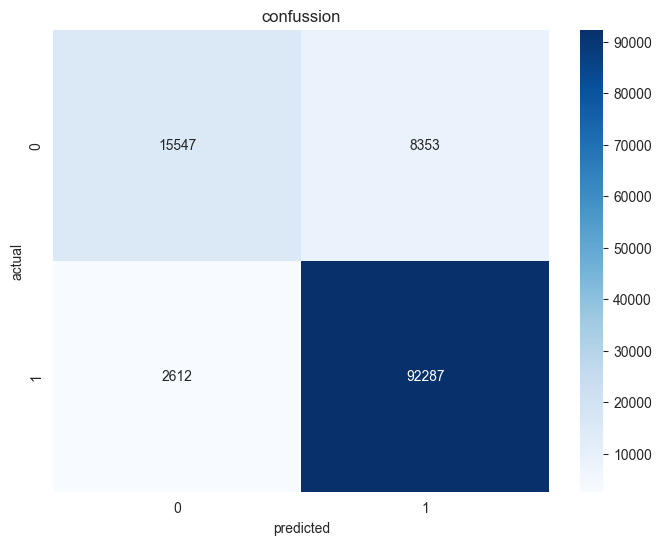

In [54]:
# 计算混淆矩阵
cm = confusion_matrix(valid[TARGET], (valid_ssp > 0.5).astype(int))
print("混淆矩阵:")
print(cm)

# 可视化混淆矩阵
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('predicted')
plt.ylabel('actual')
plt.title('confussion')